
# HAR — LSTM vs Transformer for Sequential Classification

**Goal:** Compare an **LSTM** and a **Transformer encoder** on a real sequential problem: smartphone-based **Human Activity Recognition (HAR)**. We’ll visualize data and training dynamics and report leadership-ready metrics: accuracy, macro/weighted F1, balanced accuracy, Cohen's κ, MCC, log loss, parameter counts, and inference latency.

**Dataset (public):** UCI *Human Activity Recognition Using Smartphones* (UCI HAR). We use the **Inertial Signals** windows (length 128) as sequences with 9 channels (accelerometer/gyroscope x/y/z). If download fails, we will **fall back to synthetic** data with the same shape and class balance.


## Setup

In [ ]:
import os, sys, zipfile, io, urllib.request, time, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, log_loss
)
from sklearn.model_selection import train_test_split

np.random.seed(7)
tf.random.set_seed(7)
warnings.filterwarnings("ignore")

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

Python: 3.13.7
TensorFlow: 2.20.0
NumPy: 2.3.2
Pandas: 2.3.2



## Load the UCI HAR Dataset (with fallbacks)

Attempt to download and extract the UCI HAR dataset. If unavailable, synthesize a dataset with similar shape — `(samples, time_steps=128, channels=9)` and 6 activity classes.


In [2]:
DATA_DIR = Path("data_uci_har")
HAR_DIR = DATA_DIR / "UCI HAR Dataset"

def try_download_uci_har(dest_dir: Path) -> bool:
    dest_dir.mkdir(parents=True, exist_ok=True)
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip",
    ]
    for url in urls:
        try:
            print("Attempting download:", url)
            with urllib.request.urlopen(url, timeout=60) as resp:
                data = resp.read()
            with zipfile.ZipFile(io.BytesIO(data)) as zf:
                zf.extractall(dest_dir)
            print("Downloaded & extracted to:", dest_dir.resolve())
            return True
        except Exception as e:
            print("Download failed from", url, "->", e)
    print("\nManual option: Download 'UCI HAR Dataset.zip' and unzip into:", dest_dir.resolve())
    return False

def load_inertial_har(base: Path):
    channels = [
        "body_acc_x","body_acc_y","body_acc_z",
        "body_gyro_x","body_gyro_y","body_gyro_z",
        "total_acc_x","total_acc_y","total_acc_z"
    ]
    def load_split(split):
        X_list = []
        for ch in channels:
            f = base / split / "Inertial Signals" / f"{ch}_{split}.txt"
            arr = np.loadtxt(f)  # (n_samples, 128)
            X_list.append(arr[:, :, None])
        X = np.concatenate(X_list, axis=2)  # (n, 128, 9)
        y = np.loadtxt(base / split / f"y_{split}.txt").astype(int) - 1  # map 1..6 -> 0..5
        return X, y

    X_train, y_train = load_split("train")
    X_test,  y_test  = load_split("test")
    activity_map = {
        0: "WALKING",
        1: "WALKING_UPSTAIRS",
        2: "WALKING_DOWNSTAIRS",
        3: "SITTING",
        4: "STANDING",
        5: "LAYING",
    }
    return X_train, y_train, X_test, y_test, activity_map

download_ok = False
if not HAR_DIR.exists():
    download_ok = try_download_uci_har(DATA_DIR)
else:
    download_ok = True

USE_SYNTHETIC = False
if download_ok:
    try:
        X_train, y_train, X_test, y_test, activity_map = load_inertial_har(HAR_DIR)
    except Exception as e:
        print("Failed to load inertial signals; using synthetic. Error:", e)
        USE_SYNTHETIC = True
else:
    USE_SYNTHETIC = True

if USE_SYNTHETIC:
    print("Generating synthetic dataset...")
    n_train, n_test = 6000, 2500
    time_steps, channels, n_classes = 128, 9, 6
    def make_synth(n):
        X = np.zeros((n, time_steps, channels), dtype=np.float32)
        y = np.random.randint(0, n_classes, size=n)
        t = np.linspace(0, 4*np.pi, time_steps)
        for i in range(n):
            cls = y[i]
            base_freq = (cls + 1) * 0.4
            sig = np.sin(base_freq * t)[None, :].T
            noise = 0.3 * np.random.randn(time_steps, channels)
            X[i] = sig @ np.ones((1, channels)) + noise
        return X, y
    X_train, y_train = make_synth(n_train)
    X_test,  y_test  = make_synth(n_test)
    activity_map = {i: f"CLASS_{i}" for i in range(6)}

n_classes = len(np.unique(y_train))
time_steps = X_train.shape[1]
channels   = X_train.shape[2]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Classes:", n_classes, activity_map)

Train shape: (7352, 128, 9)  Test shape: (2947, 128, 9)
Classes: 6 {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING', 4: 'STANDING', 5: 'LAYING'}



## Explore data & visualize sequences


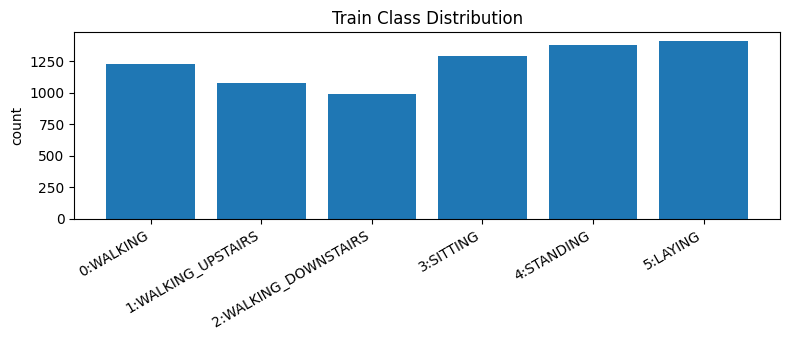

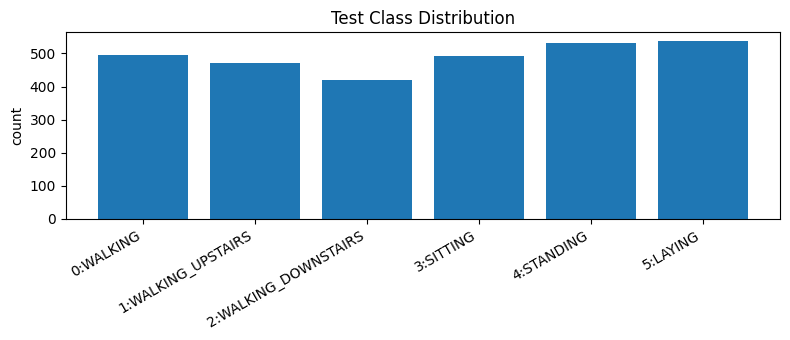

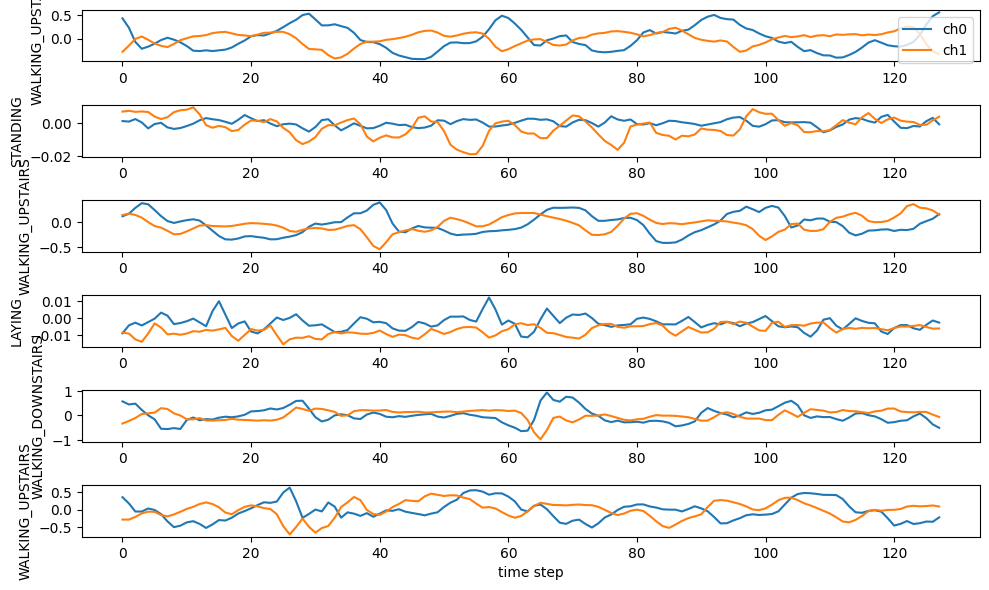

In [3]:
def plot_class_counts(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    labels = [f"{i}:{activity_map[i]}" for i in counts.index]
    plt.figure(figsize=(8,3.5)); plt.bar(labels, counts.values)
    plt.title(title); plt.ylabel("count"); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

plot_class_counts(y_train, "Train Class Distribution")
plot_class_counts(y_test,  "Test Class Distribution")

def plot_example_sequences(X, y, n=6):
    idxs = np.random.choice(len(X), size=n, replace=False)
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(idxs, 1):
        ax = plt.subplot(n, 1, i)
        ax.plot(X[idx, :, 0], label="ch0")
        ax.plot(X[idx, :, 1], label="ch1")
        ax.set_ylabel(f"{activity_map[int(y[idx])]}")
        if i == 1: ax.legend(loc='upper right')
    plt.xlabel("time step"); plt.tight_layout(); plt.show()

plot_example_sequences(X_train, y_train, n=6)


## Train/Validation split & preprocessing


In [4]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=7)

mu = X_tr.mean(axis=(0,1), keepdims=True)
sd = X_tr.std(axis=(0,1), keepdims=True) + 1e-8
X_tr  = (X_tr  - mu) / sd
X_val = (X_val - mu) / sd
X_te  = (X_test - mu) / sd

def to_onehot(y, n_classes):
    Y = np.zeros((len(y), n_classes), dtype=np.float32)
    Y[np.arange(len(y)), y] = 1.0
    return Y

Y_tr, Y_val, Y_te = to_onehot(y_tr, n_classes), to_onehot(y_val, n_classes), to_onehot(y_test, n_classes)

print("Standardized shapes:", X_tr.shape, X_val.shape, X_te.shape)

Standardized shapes: (5881, 128, 9) (1471, 128, 9) (2947, 128, 9)


## Models


In [5]:
def build_lstm_model(time_steps, channels, n_classes, units=64, dropout=0.3):
    model = keras.Sequential([
        layers.Input(shape=(time_steps, channels)),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def positional_encoding_sincos(length, d_model):
    positions = np.arange(length)[:, None]
    div_terms = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((length, d_model), dtype=np.float32)
    pe[:, 0::2] = np.sin(positions * div_terms)
    pe[:, 1::2] = np.cos(positions * div_terms)
    return tf.constant(pe[None, ...])

class AddPositionalEncoding(layers.Layer):
    def __init__(self, length, d_model, **kwargs):
        super().__init__(**kwargs)
        self.pe = positional_encoding_sincos(length, d_model)
    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :]

def transformer_encoder_block(x, num_heads=4, key_dim=16, ff_dim=128, dropout=0.2):
    h = layers.LayerNormalization()(x)
    h = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(h, h)
    h = layers.Dropout(dropout)(h)
    x = layers.Add()([x, h])

    h2 = layers.LayerNormalization()(x)
    h2 = layers.Dense(ff_dim, activation="gelu")(h2)
    h2 = layers.Dropout(dropout)(h2)
    h2 = layers.Dense(num_heads * key_dim)(h2)
    h2 = layers.Dropout(dropout)(h2)
    x = layers.Add()([x, h2])
    return x

def build_transformer_model(time_steps, channels, n_classes, d_model=64, depth=2, heads=4, key_dim=16, ff_dim=128, dropout=0.2):
    inp = layers.Input(shape=(time_steps, channels))
    x = layers.Dense(d_model)(inp)
    x = AddPositionalEncoding(time_steps, d_model)(x)
    for _ in range(depth):
        x = transformer_encoder_block(x, num_heads=heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

## Train


In [6]:
print("Training LSTM…")
lstm = build_lstm_model(time_steps, channels, n_classes, units=64, dropout=0.3)
hist_lstm = lstm.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=30, batch_size=128, verbose=2)
lstm_test_loss, lstm_test_acc = lstm.evaluate(X_te, Y_te, verbose=0)

print("Training Transformer…")
trf = build_transformer_model(time_steps, channels, n_classes, d_model=64, depth=2, heads=4, key_dim=16, ff_dim=128, dropout=0.2)
hist_trf = trf.fit(X_tr, Y_tr, validation_data=(X_val, Y_val), epochs=30, batch_size=128, verbose=2)
trf_test_loss, trf_test_acc = trf.evaluate(X_te, Y_te, verbose=0)

import pandas as pd
results = [
    {"model": "LSTM", "test_acc": float(lstm_test_acc), "params": lstm.count_params()},
    {"model": "Transformer", "test_acc": float(trf_test_acc), "params": trf.count_params()}
]
res_df = pd.DataFrame(results).sort_values("test_acc", ascending=False).reset_index(drop=True)
display(res_df)

Training LSTM…
Epoch 1/30
46/46 - 2s - 48ms/step - accuracy: 0.5263 - loss: 1.2661 - val_accuracy: 0.7294 - val_loss: 0.7352
Epoch 2/30
46/46 - 2s - 34ms/step - accuracy: 0.7203 - loss: 0.6653 - val_accuracy: 0.8144 - val_loss: 0.5508
Epoch 3/30
46/46 - 2s - 36ms/step - accuracy: 0.8259 - loss: 0.4721 - val_accuracy: 0.8824 - val_loss: 0.3484
Epoch 4/30
46/46 - 2s - 39ms/step - accuracy: 0.9090 - loss: 0.2850 - val_accuracy: 0.9252 - val_loss: 0.2321
Epoch 5/30
46/46 - 2s - 41ms/step - accuracy: 0.9271 - loss: 0.2176 - val_accuracy: 0.9320 - val_loss: 0.2044
Epoch 6/30
46/46 - 2s - 40ms/step - accuracy: 0.9447 - loss: 0.1689 - val_accuracy: 0.9375 - val_loss: 0.1650
Epoch 7/30
46/46 - 2s - 44ms/step - accuracy: 0.9514 - loss: 0.1419 - val_accuracy: 0.9375 - val_loss: 0.1720
Epoch 8/30
46/46 - 2s - 38ms/step - accuracy: 0.9495 - loss: 0.1411 - val_accuracy: 0.9436 - val_loss: 0.1511
Epoch 9/30
46/46 - 2s - 41ms/step - accuracy: 0.9560 - loss: 0.1213 - val_accuracy: 0.9463 - val_loss: 0.

,model,test_acc,params
0,LSTM,0.904309,23494
1,Transformer,0.847642,72134


## Learning curves & capacity vs accuracy


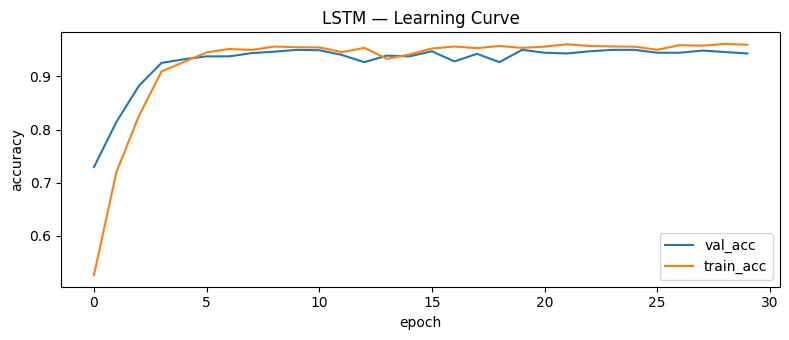

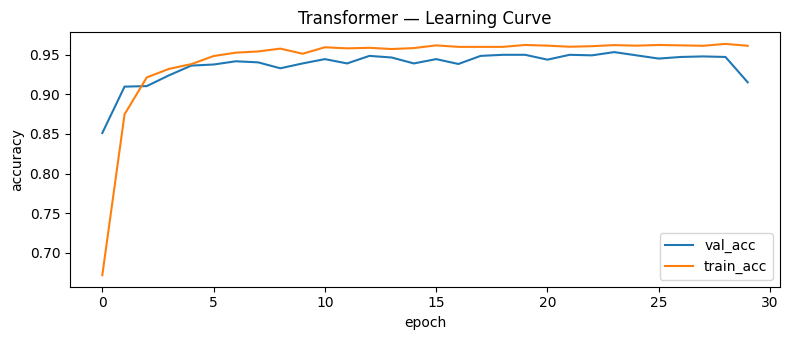

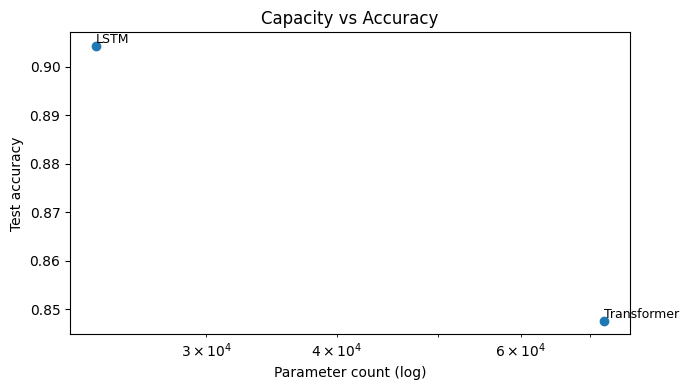

In [7]:
def plot_learning_curve(hist, title):
    plt.figure(figsize=(8,3.5))
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.title(title); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curve(hist_lstm, "LSTM — Learning Curve")
plot_learning_curve(hist_trf, "Transformer — Learning Curve")

plt.figure(figsize=(7,4))
plt.scatter(res_df["params"], res_df["test_acc"])
for i, r in res_df.iterrows():
    plt.text(r["params"], r["test_acc"], r["model"], fontsize=9, ha="left", va="bottom")
plt.xscale("log")
plt.xlabel("Parameter count (log)"); plt.ylabel("Test accuracy"); plt.title("Capacity vs Accuracy"); plt.tight_layout(); plt.show()

## Rich metrics & confusion matrices


LSTM metrics:
                    precision    recall  f1-score   support

           WALKING       0.98      0.91      0.94       496
  WALKING_UPSTAIRS       0.89      0.97      0.93       471
WALKING_DOWNSTAIRS       0.89      0.96      0.92       420
           SITTING       0.80      0.85      0.82       491
          STANDING       0.87      0.80      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.91      0.91      0.90      2947
      weighted avg       0.91      0.90      0.90      2947



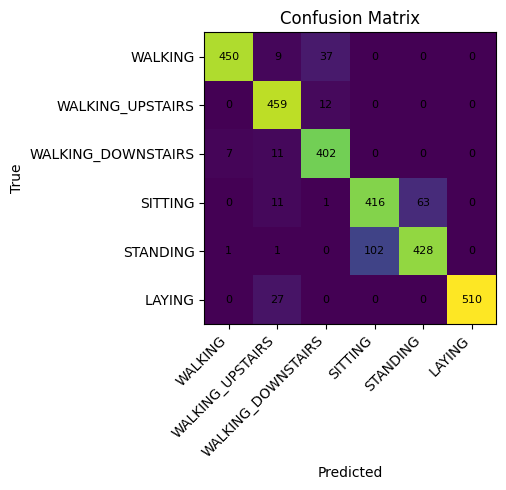


Transformer metrics:
                    precision    recall  f1-score   support

           WALKING       1.00      0.65      0.79       496
  WALKING_UPSTAIRS       0.80      0.87      0.83       471
WALKING_DOWNSTAIRS       0.73      1.00      0.84       420
           SITTING       0.80      0.75      0.78       491
          STANDING       0.82      0.83      0.83       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.85      2947
         macro avg       0.86      0.85      0.84      2947
      weighted avg       0.86      0.85      0.85      2947



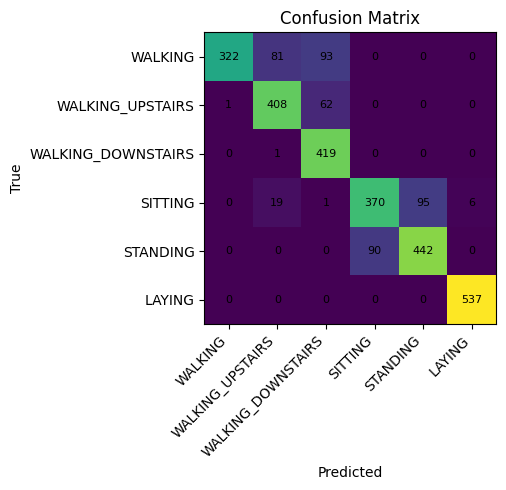

,accuracy,balanced_accuracy,precision_macro,precision_weighted,recall_macro,recall_weighted,f1_macro,f1_weighted,cohen_kappa,mcc,log_loss
model,,,,,,,,,,,
LSTM,0.904309,0.906734,0.905465,0.907121,0.906734,0.904309,0.904862,0.904490,0.885125,0.885603,0.392909
Transformer,0.847642,0.849574,0.857260,0.862553,0.849574,0.847642,0.843450,0.845584,0.817243,0.820442,1.075144


In [8]:
def evaluate_model(model, X, y_true, label_names):
    prob = model.predict(X, batch_size=256, verbose=0)
    y_pred = prob.argmax(axis=1)
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_weighted": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "cohen_kappa": cohen_kappa_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "log_loss": log_loss(y_true, prob)
    }
    print(classification_report(y_true, y_pred, target_names=[label_names[i] for i in range(len(label_names))]))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(label_names))); ax.set_yticks(range(len(label_names)))
    ax.set_xticklabels([label_names[i] for i in range(len(label_names))], rotation=45, ha='right')
    ax.set_yticklabels([label_names[i] for i in range(len(label_names))])
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
    plt.tight_layout(); plt.show()
    return out

print("LSTM metrics:")
lstm_metrics = evaluate_model(lstm, X_te, y_test, activity_map)
print("\nTransformer metrics:")
trf_metrics = evaluate_model(trf, X_te, y_test, activity_map)

metrics_df = pd.DataFrame([{"model":"LSTM", **lstm_metrics},{"model":"Transformer", **trf_metrics}]).set_index("model")
display(metrics_df)

## Practicality: inference latency


In [9]:
def benchmark_inference(model, X, batch_sizes=[1, 32, 128, 512]):
    rows = []
    for b in batch_sizes:
        _ = model.predict(X[:b], verbose=0)  # warmup
        t0 = time.time()
        _ = model.predict(X[:b], verbose=0)
        t1 = time.time()
        rows.append({"batch": b, "ms_per_batch": (t1 - t0)*1000.0})
    return pd.DataFrame(rows)

print("LSTM latency:")
lat_lstm = benchmark_inference(lstm, X_te)
print(lat_lstm)

print("\nTransformer latency:")
lat_trf = benchmark_inference(trf, X_te)
print(lat_trf)

LSTM latency:
   batch  ms_per_batch
0      1     22.681952
1     32     22.567749
2    128     40.116787
3    512     89.583158

Transformer latency:
   batch  ms_per_batch
0      1     24.461746
1     32     45.144796
2    128    133.338928
3    512    490.933895


## What leaders should look for

- **Generalization**: unseen-subject test split aligns with deployment.
- **Lift vs complexity**: does Transformer improve macro-F1 over LSTM with acceptable latency/size?
- **Curves**: stable convergence; avoid overfitting (train ≫ val).
- **Per-class behavior**: e.g., **Sitting vs Standing** confusion—impact on actions.
- **Latency & size**: ensure edge/wearable constraints are met.
- **Robustness**: test across placements/devices; monitor drift post updates.
- **Governance**: document pipeline, seeds, versions, and splits.



## References
- UCI Machine Learning Repository — *Human Activity Recognition Using Smartphones (HAR)*.
- Vaswani et al., *Attention Is All You Need* (2017).
